In [1]:
img_path = r"data\sdss\sdss_image_180.451206348309_-0.324013595202261.jpg"

sigma = 25
kernel_size = 25

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import filter_toolbox
from scipy.signal import find_peaks
import Interface as mi
import numpy as np 
from Pipeline import Pipeline as model_pipeline
from scipy.signal import find_peaks 
import matplotlib.pyplot as plt

In [3]:
"""M, N =120,120
for ksize in range(3, 20, 2):
    for sigma in [1,2,3,4]:
        print(ksize,sigma)
        filter_toolbox.new_get_convolution(img_path, kernel_size=ksize, sigma=sigma,  debug=True)"""

'M, N =120,120\nfor ksize in range(3, 20, 2):\n    for sigma in [1,2,3,4]:\n        print(ksize,sigma)\n        filter_toolbox.new_get_convolution(img_path, kernel_size=ksize, sigma=sigma,  debug=True)'

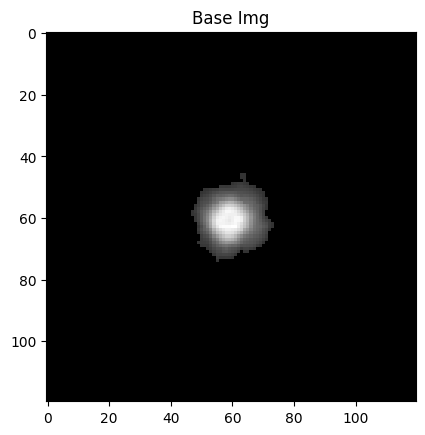

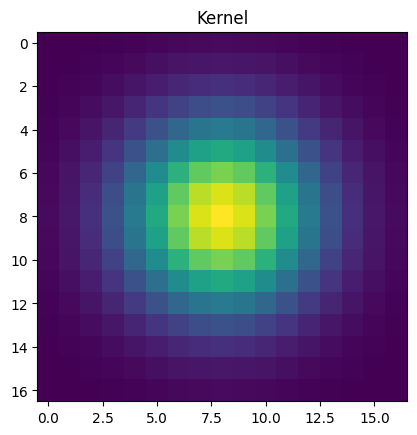

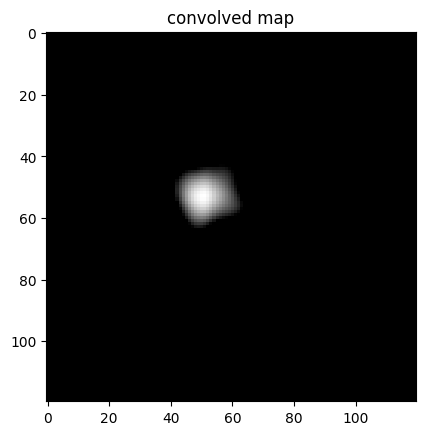

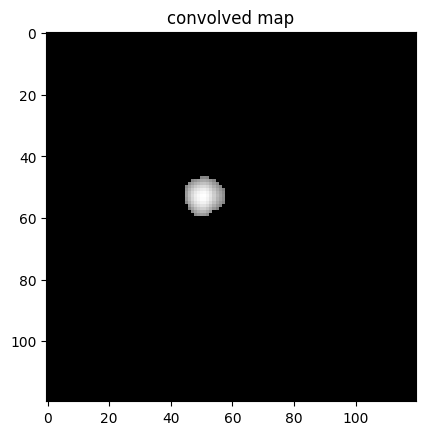

In [4]:
map = filter_toolbox.new_get_convolution(img_path, kernel_size=17, sigma=3,  filter_ths=0.2, debug=True)

threshold_value =  0.5*map.max()
_, mask = cv2.threshold(map, threshold_value, 255, cv2.THRESH_BINARY)
resultado = cv2.bitwise_and(map, map, mask=mask.astype(np.uint8))
resultado_final = np.where(mask > 0, map, 0)

plt.imshow(resultado_final, cmap='gray')
plt.title("convolved map")
plt.show()

## Gerar picos

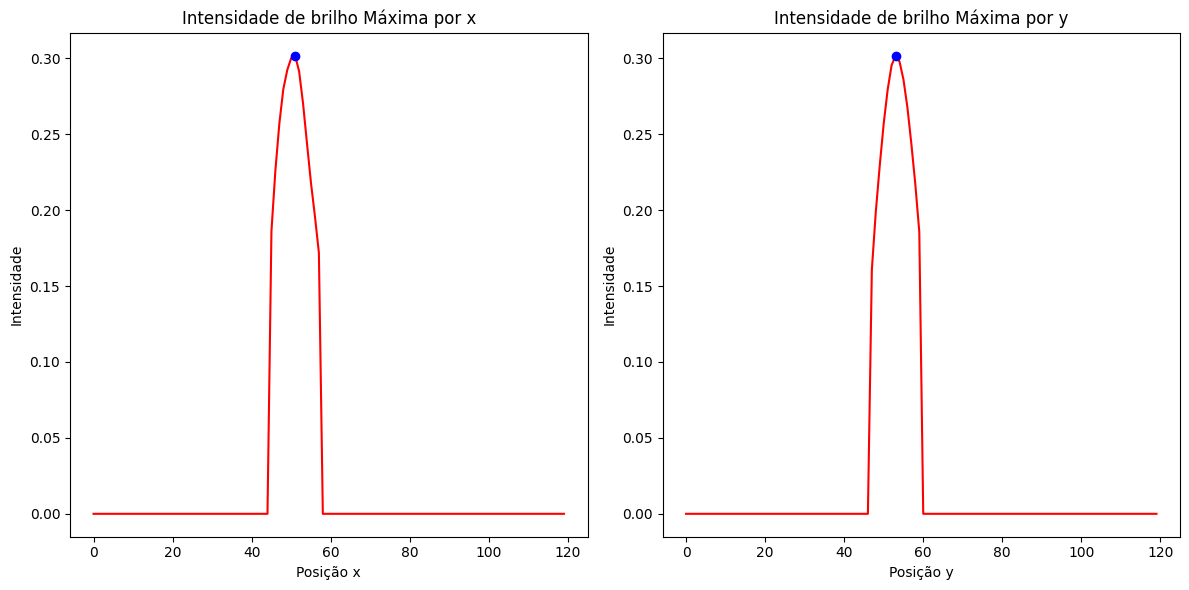

In [5]:
# Obter a intensidade ao longo das dimensões x e y
intensity = np.stack(resultado_final, axis=0)

# Encontrar o maior valor ao longo da dimensão y para cada x
max_by_x = intensity.max(axis=0)  # Máximo ao longo da dimensão y

# Encontrar o maior valor ao longo da dimensão x para cada y
max_by_y = intensity.max(axis=1)  # Máximo ao longo da dimensão x

# Obter os valores de x e y
x_values = np.arange(intensity.shape[1])
y_values = np.arange(intensity.shape[0])

# Encontrar picos para a curva de intensidade por x
prominence_x = 0.01 * max(max_by_x)  # Prominência de 20% do valor máximo observado
peaks_x, _ = find_peaks(max_by_x, prominence=prominence_x)

# Encontrar picos para a curva de intensidade por y
prominence_y = 0.01 * max(max_by_y)  # Prominência de 20% do valor máximo observado
peaks_y, _ = find_peaks(max_by_y, prominence=prominence_y)

# Criar o gráfico
plt.figure(figsize=(12, 6))

# Plotar a curva de intensidade por x
plt.subplot(1, 2, 1)
plt.plot(x_values, max_by_x, color='red')
plt.plot(x_values[peaks_x], max_by_x[peaks_x], 'bo', label='Picos')
plt.title('Intensidade de brilho Máxima por x')
plt.xlabel('Posição x')
plt.ylabel('Intensidade')

# Plotar a curva de intensidade por y
plt.subplot(1, 2, 2)
plt.plot(y_values, max_by_y, color='red')
plt.plot(y_values[peaks_y], max_by_y[peaks_y], 'bo', label='Picos')
plt.title('Intensidade de brilho Máxima por y')
plt.xlabel('Posição y')
plt.ylabel('Intensidade')

plt.tight_layout()
plt.show()


In [6]:
intensidades_x = max_by_x[peaks_x]
intensidades_y = max_by_y[peaks_y]

ordenado_x = np.argsort(intensidades_x)[::-1]  # Índices dos picos ordenados por intensidade (decrescente)
ordenado_y = np.argsort(intensidades_y)[::-1]  # Índices dos picos ordenados por intensidade (decrescente)

# Emparelhar picos baseados na ordem de intensidade
pares_picos = []
num_pares = min(len(ordenado_x), len(ordenado_y))  # Garantir que não ultrapasse o número de picos disponíveis

for i in range(num_pares):
    x_idx = peaks_x[ordenado_x[i]]
    y_idx = peaks_y[ordenado_y[i]]
    pares_picos.append((x_values[x_idx], y_values[y_idx]))

pares_picos

[(51, 53)]

In [7]:
peaks_y, max_by_y[peaks_y]

(array([53], dtype=int64), array([0.30164453], dtype=float32))

In [8]:
peaks_x, max_by_x[peaks_x]

(array([51], dtype=int64), array([0.30164453], dtype=float32))

In [9]:
import numpy as np

intensidades_x = max_by_x[peaks_x]
intensidades_y = max_by_y[peaks_y]

# Ordenar os índices dos picos por intensidade (decrescente)
ordenado_x = np.argsort(intensidades_x)[::-1]  # Índices ordenados de intensidades no eixo x
ordenado_y = np.argsort(intensidades_y)[::-1]  # Índices ordenados de intensidades no eixo y

# Emparelhar picos baseados na ordem de intensidade, permitindo compartilhamento de posição em x
pares_picos = []

# Conjunto para acompanhar os picos já emparelhados no eixo y
usados_y = set()

# Emparelhar os picos de y com os picos de x, permitindo que um pico x seja reutilizado
for x_idx in ordenado_x:
    for y_idx in ordenado_y:
        if y_idx in usados_y:
            continue  # Pule se este índice de y já foi usado
        
        # Emparelhar o valor de x com o valor de y
        pares_picos.append((x_values[peaks_x[x_idx]], y_values[peaks_y[y_idx]]))
        
        # Marcar o pico y como usado
        usados_y.add(y_idx)
        
        # Avança para o próximo pico y, mas o mesmo x_idx pode ser reutilizado
        break

# Se ainda houver picos em y não emparelhados, continue emparelhando com o último x disponível
last_x_value = x_values[peaks_x[ordenado_x[-4]]]  # Último valor de x disponível
for y_idx in ordenado_y:
    if y_idx not in usados_y:
        pares_picos.append((last_x_value, y_values[peaks_y[y_idx]]))
        usados_y.add(y_idx)

pares_picos


IndexError: index -4 is out of bounds for axis 0 with size 1

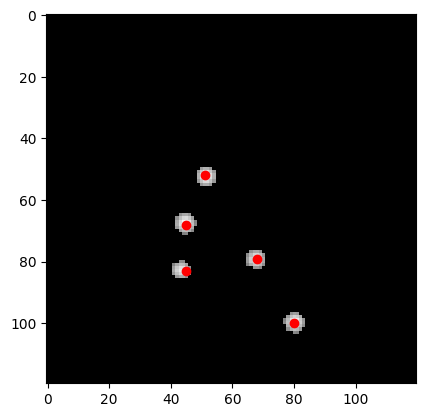

In [ ]:
# Visualizar a imagem e as posições detectadas
plt.imshow(resultado_final, cmap='gray')
# Marcar as posições das estrelas na imagem
for (x, y) in pares_picos:
    plt.scatter([x], [y], color='red')
plt.show()

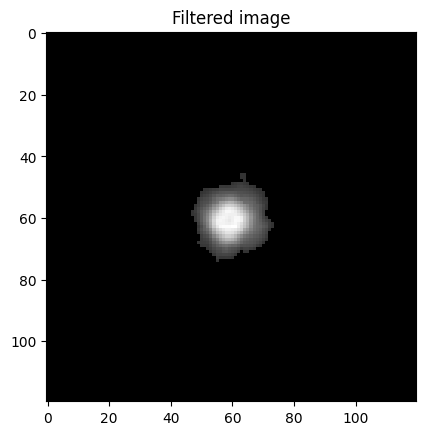

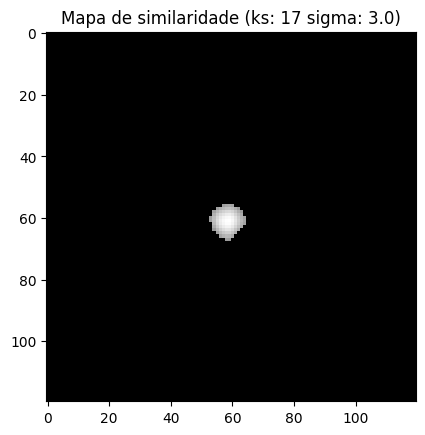

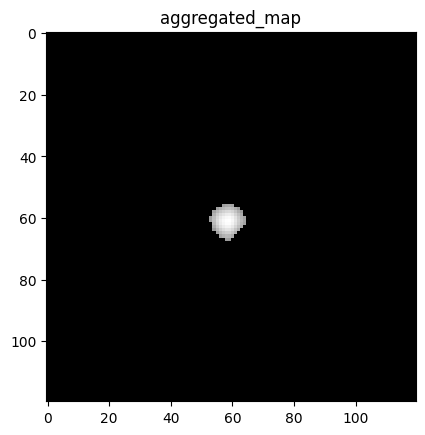

In [10]:
input_data = mi.PipelineInput(
    img_path = img_path,
    filter_intensity=0.2,
    kernel_param=[mi.KernelParam(size=17, sigma=3),
                  ],
    agg_type=np.max
)
model = model_pipeline(is_debug=True)
agg=model.run(input_data=input_data)

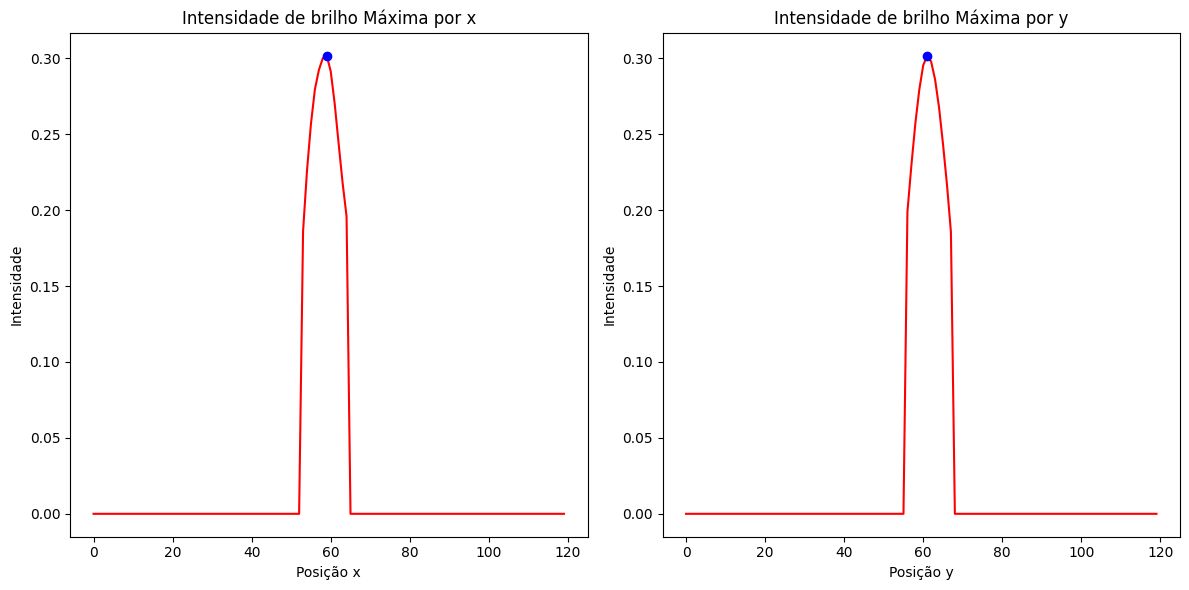

In [11]:
resultado_final = agg.map
# Obter a intensidade ao longo das dimensões x e y
intensity = np.stack(resultado_final, axis=0)

# Encontrar o maior valor ao longo da dimensão y para cada x
max_by_x = intensity.max(axis=0)  # Máximo ao longo da dimensão y

# Encontrar o maior valor ao longo da dimensão x para cada y
max_by_y = intensity.max(axis=1)  # Máximo ao longo da dimensão x

# Obter os valores de x e y
x_values = np.arange(intensity.shape[1])
y_values = np.arange(intensity.shape[0])

# Encontrar picos para a curva de intensidade por x
prominence_x = 0.50 * max(max_by_x)  # Prominência de 20% do valor máximo observado
peaks_x, _ = find_peaks(max_by_x, prominence=prominence_x)

# Encontrar picos para a curva de intensidade por y
prominence_y = 0.5 * max(max_by_y)  # Prominência de 20% do valor máximo observado
peaks_y, _ = find_peaks(max_by_y, prominence=prominence_y)

# Criar o gráfico
plt.figure(figsize=(12, 6))

# Plotar a curva de intensidade por x
plt.subplot(1, 2, 1)
plt.plot(x_values, max_by_x, color='red')
plt.plot(x_values[peaks_x], max_by_x[peaks_x], 'bo', label='Picos')
plt.title('Intensidade de brilho Máxima por x')
plt.xlabel('Posição x')
plt.ylabel('Intensidade')

# Plotar a curva de intensidade por y
plt.subplot(1, 2, 2)
plt.plot(y_values, max_by_y, color='red')
plt.plot(y_values[peaks_y], max_by_y[peaks_y], 'bo', label='Picos')
plt.title('Intensidade de brilho Máxima por y')
plt.xlabel('Posição y')
plt.ylabel('Intensidade')

plt.tight_layout()
plt.show()
